# Interaction

_“A graphic is not ‘drawn’ once and for all; it is ‘constructed’ and reconstructed until it reveals all the relationships constituted by the interplay of the data. The best graphic operations are those carried out by the decision-maker themself.”_ &mdash; [Jacques Bertin](https://books.google.com/books?id=csqX_xnm4tcC)

Visualization provides a powerful means of making sense of data. A single image, however, typically provides answers to, at best, a handful of questions. Through _interaction_ we can transform static images into tools for exploration: highlighting points of interest, zooming in to reveal finer-grained patterns, and linking across multiple views to reason about multi-dimensional relationships.

At the core of interaction is the notion of a _selection_: a means of indicating to the computer which elements or regions we are interested in. For example, we might hover the mouse over a point, click multiple marks, or draw a bounding box around a region to highlight subsets of the data for further scrutiny.

Alongside visual encodings and data transformations, Altair provides a _selection_ abstraction for authoring interactions. These selections encompass three aspects:

1. Input event handling to select points or regions of interest, such as mouse hover, click, drag, scroll, and touch events.
2. Generalizing from the input to form a selection rule (or [_predicate_](https://en.wikipedia.org/wiki/Predicate_%28mathematical_logic%29)) that determines whether or not a given data record lies within the selection.
3. Using the selection predicate to dynamically configure a visualization by driving _conditional encodings_, _filter transforms_, or _scale domains_.

This notebook introduces interactive selections and explores how to use them to author a variety of interaction techniques, such as dynamic queries, panning &amp; zooming, details-on-demand, and brushing &amp; linking.

_This notebook is part of the [data visualization curriculum](https://github.com/uwdata/visualization-curriculum)._

In [1]:
import pandas as pd
import altair as alt

## Datasets

We will visualize a variety of datasets from the [vega-datasets](https://github.com/vega/vega-datasets) collection:

- A dataset of `cars` from the 1970s and early 1980s,
- A dataset of `movies`, previously used in the [Data Transformation](https://github.com/uwdata/visualization-curriculum/blob/master/altair_data_transformation.ipynb) notebook,
- A dataset containing ten years of [S&amp;P 500](https://en.wikipedia.org/wiki/S%26P_500_Index) (`sp500`) stock prices,
- A dataset of technology company `stocks`, and
- A dataset of `flights`, including departure time, distance, and arrival delay.

In [2]:
cars = 'https://vega.github.io/vega-datasets/data/cars.json'
movies = 'https://vega.github.io/vega-datasets/data/movies.json'
sp500 = 'https://vega.github.io/vega-datasets/data/sp500.csv'
stocks = 'https://vega.github.io/vega-datasets/data/stocks.csv'
flights = 'https://vega.github.io/vega-datasets/data/flights-5k.json'

## Introducing Selections

Let's start with a basic selection: simply clicking a point to highlight it. Using the `cars` dataset, we'll start with a scatter plot of horsepower versus miles per gallon, with a color encoding for the number cylinders in the car engine.

In addition, we'll create a selection instance by calling `alt.selection_single()`, indicating we want a selection defined over a _single value_. By default, the selection uses a mouse click to determine the selected value. To register a selection with a chart, we must add it using the `.add_selection()` method.

Once our selection has been defined, we can use it as a parameter for _conditional encodings_, which apply a different encoding depending on whether a data record lies in or out of the selection. For example, consider the following code:

~~~ python
color=alt.condition(selection, 'Cylinders:O', alt.value('grey'))
~~~

This encoding definition states that data points contained within the `selection` should be colored according to the `Cylinder` field, while non-selected data points should use a default `grey`. An empty selection includes _all_ data points, and so initially all points will be colored.

_Try clicking different points in the chart below. What happens? (Click the background to clear the selection state and return to an "empty" selection.)_

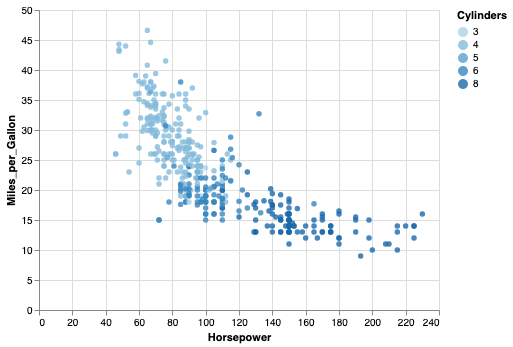

In [3]:
selection = alt.selection_single();
  
alt.Chart(cars).mark_circle().add_selection(
    selection
).encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color=alt.condition(selection, 'Cylinders:O', alt.value('grey')),
    opacity=alt.condition(selection, alt.value(0.8), alt.value(0.1))
)

Of course, highlighting individual data points one-at-a-time is not particularly exciting! As we'll see, however, single value selections provide a useful building block for more powerful interactions. Moreover, single value selections are just one of the three selection types provided by Altair:

- `selection_single` - select a single discrete value, by default on click events. 
- `selection_multi` - select multiple discrete values. The first value is selected on mouse click and additional values toggled using shift-click. 
- `selection_interval` - select a continuous range of values, initiated by mouse drag.

Let's compare each of these selection types side-by-side. To keep our code tidy we'll first define a function (`plot`) that generates a scatter plot specification just like the one above. We can pass a selection to the `plot` function to have it applied to the chart:

In [4]:
def plot(selection):
    return alt.Chart(cars).mark_circle().add_selection(
        selection
    ).encode(
        x='Horsepower:Q',
        y='Miles_per_Gallon:Q',
        color=alt.condition(selection, 'Cylinders:O', alt.value('grey')),
        opacity=alt.condition(selection, alt.value(0.8), alt.value(0.1))
    ).properties(
        width=240,
        height=180
    )

Let's use our `plot` function to create three chart variants, one per selection type.

The first (`single`) chart replicates our earlier example. The second (`multi`) chart supports shift-click interactions to toggle inclusion of multiple points within the selection. The third (`interval`) chart generates a selection region (or _brush_) upon mouse drag. Once created, you can drag the brush around to select different points, or scroll when the cursor is inside the brush to scale (zoom) the brush size.

_Try interacting with each of the charts below!_

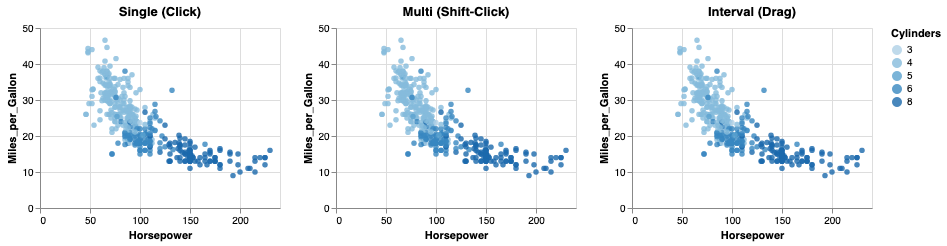

In [5]:
alt.hconcat(
  plot(alt.selection_single()).properties(title='Single (Click)'),
  plot(alt.selection_multi()).properties(title='Multi (Shift-Click)'),
  plot(alt.selection_interval()).properties(title='Interval (Drag)')
)

The examples above use default interactions (click, shift-click, drag) for each selection type. We can further customize the interactions by providing input event specifications using [Vega event selector syntax](https://vega.github.io/vega/docs/event-streams/). For example, we can modify our `single` and `multi` charts to trigger upon `mouseover` events instead of `click` events.

_Hold down the shift key in the second chart to "paint" with data!_

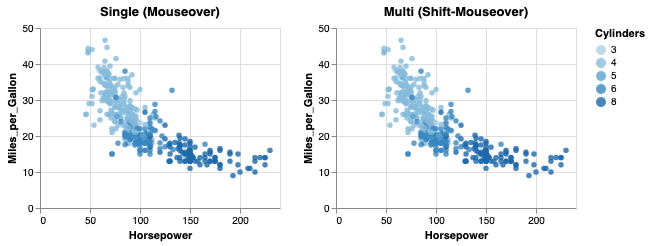

In [6]:
alt.hconcat(
  plot(alt.selection_single(on='mouseover')).properties(title='Single (Mouseover)'),
  plot(alt.selection_multi(on='mouseover')).properties(title='Multi (Shift-Mouseover)')
)

Now that we've covered the basics of Altair selections, let's take a tour through the various interaction techniques they enable!

## Dynamic Queries

_Dynamic queries_ enables rapid, reversible exploration of data to isolate patterns of interest. As defined by [Ahlberg, Williamson, &amp; Shneiderman](https://www.cs.umd.edu/~ben/papers/Ahlberg1992Dynamic.pdf), a dynamic query:

- represents a query graphically,
- provides visible limits on the query range,
- provides a graphical representation of the data and query result,
- gives immediate feedback of the result after every query adjustment,
- and allows novice users to begin working with little training.

A common approach is to manipulate query parameters using standard user interface widgets such as sliders, radio buttons, and drop-down menus. To generate dynamic query widgets, we can apply a selection's `bind` operation to one or more data fields we wish to query.

Let's build an interactive scatter plot that uses a dynamic query to filter the display. Given a scatter plot of movie ratings (from Rotten Tomates and IMDB), we can add a selection over the `Major_Genre` field to enable interactive filtering by film genre.

To start, let's extract the unique (non-null) genres from the `movies` data:

In [7]:
df = pd.read_json(movies) # load movies data
genres = df['Major_Genre'].unique() # get unique field values
genres = list(filter(lambda d: d is not None, genres)) # filter out None values
genres.sort() # sort alphabetically

For later use, let's also define a list of unique `MPAA_Rating` values:

In [8]:
mpaa = ['G', 'PG', 'PG-13', 'R', 'NC-17', 'Not Rated']

Now let's create a `single` selection bound to a drop-down menu.

*Use the dynamic query menu below to explore the data. How do ratings vary by genre? How would you revise the code to filter `MPAA_Rating` (G, PG, PG-13, etc.) instead of `Major_Genre`?*

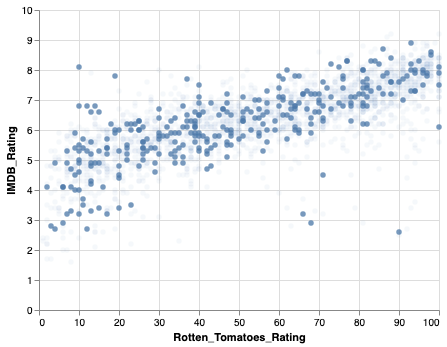

In [9]:
selectGenre = alt.selection_single(
    name='Select', # name the selection 'Select'
    fields=['Major_Genre'], # limit selection to the Major_Genre field
    init={'Major_Genre': genres[0]}, # use first genre entry as initial value
    bind=alt.binding_select(options=genres) # bind to a menu of unique genre values
)

alt.Chart(movies).mark_circle().add_selection(
    selectGenre
).encode(
    x='Rotten_Tomatoes_Rating:Q',
    y='IMDB_Rating:Q',
    tooltip='Title:N',
    opacity=alt.condition(selectGenre, alt.value(0.75), alt.value(0.05))
)

Our construction above leverages multiple aspects of selections:

- We give the selection a name (`'Select'`). This name is not required, but allows us to influence the label text of the generated dynamic query menu. (_What happens if you remove the name? Try it!_)
- We constrain the selection to a specific data field (`Major_Genre`). Earlier when we used a `single` selection, the selection mapped to individual data points. By limiting the selection to a specific field, we can select _all_ data points whose `Major_Genre` field value matches the single selected value.
- We initialize `init=...` the selection to a starting value.
- We `bind` the selection to an interface widget, in this case a drop-down menu via `binding_select`.
- As before, we then use a conditional encoding to control the opacity channel.

### Binding Selections to Multiple Inputs

One selection instance can be bound to _multiple_ dynamic query widgets. Let's modify the example above to provide filters for _both_ `Major_Genre` and `MPAA_Rating`, using radio buttons instead of a menu. Our `single` selection is now defined over a single _pair_ of genre and MPAA rating values

_Look for surprising conjunctions of genre and rating. Are there any G or PG-rated horror films?_

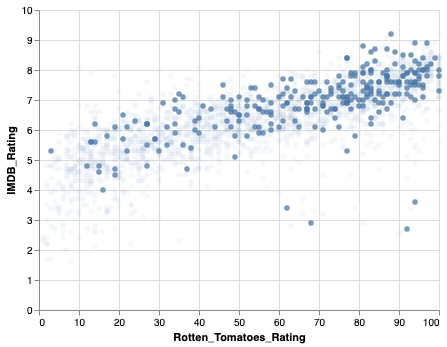

In [10]:
# single-value selection over [Major_Genre, MPAA_Rating] pairs
# use specific hard-wired values as the initial selected values
selection = alt.selection_single(
    name='Select',
    fields=['Major_Genre', 'MPAA_Rating'],
    init={'Major_Genre': 'Drama', 'MPAA_Rating': 'R'},
    bind={'Major_Genre': alt.binding_select(options=genres), 'MPAA_Rating': alt.binding_radio(options=mpaa)}
)
  
# scatter plot, modify opacity based on selection
alt.Chart(movies).mark_circle().add_selection(
    selection
).encode(
    x='Rotten_Tomatoes_Rating:Q',
    y='IMDB_Rating:Q',
    tooltip='Title:N',
    opacity=alt.condition(selection, alt.value(0.75), alt.value(0.05))
)

_Fun facts: The PG-13 rating didn't exist when the movies [Jaws](https://www.imdb.com/title/tt0073195/) and [Jaws 2](https://www.imdb.com/title/tt0077766/) were released. The first film to receive a PG-13 rating was 1984's [Red Dawn](https://www.imdb.com/title/tt0087985/)._

### Using Visualizations as Dynamic Queries

Though standard interface widgets show the _possible_ query parameter values, they do not visualize the _distribution_ of those values. We might also wish to use richer interactions, such as multi-value or interval selections, rather than input widgets that select only a single value at a time.

To address these issues, we can author additional charts to both visualize data and support dynamic queries. Let's add a histogram of the count of films per year and use an interval selection to dynamically highlight films over selected time periods.

*Interact with the year histogram to explore films from different time periods. Do you seen any evidence of [sampling bias](https://en.wikipedia.org/wiki/Sampling_bias) across the years? (How do year and critics' ratings relate?)*

_The years range from 1930 to 2040! Are future films in pre-production, or are there "off-by-one century" errors? Also, depending on which time zone you're in, you may see a small bump in either 1969 or 1970. Why might that be? (See the end of the notebook for an explanation!)_

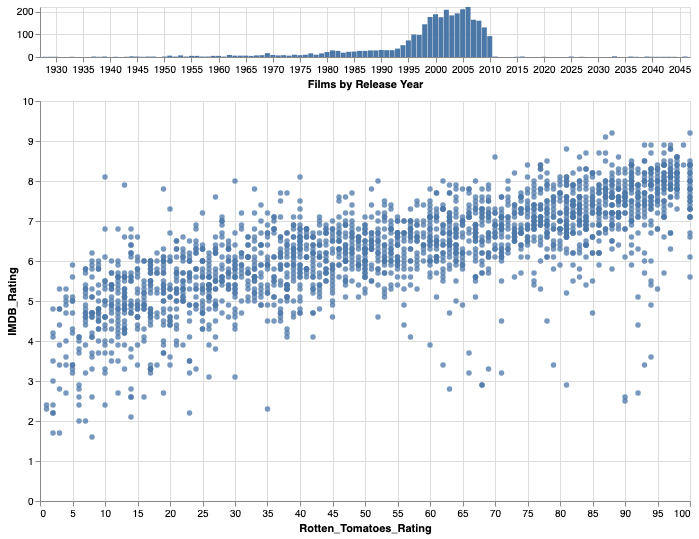

In [11]:
brush = alt.selection_interval(
    encodings=['x'] # limit selection to x-axis (year) values
)

# dynamic query histogram
years = alt.Chart(movies).mark_bar().add_selection(
    brush
).encode(
    alt.X('year(Release_Date):T', title='Films by Release Year'),
    alt.Y('count():Q', title=None)
).properties(
    width=650,
    height=50
)

# scatter plot, modify opacity based on selection
ratings = alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating:Q',
    y='IMDB_Rating:Q',
    tooltip='Title:N',
    opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05))
).properties(
    width=650,
    height=400
)

alt.vconcat(years, ratings).properties(spacing=5)

The example above provides dynamic queries using a _linked selection_ between charts:

- We create an `interval` selection (`brush`), and set `encodings=['x']` to limit the selection to the x-axis only, resulting in a one-dimensional selection interval.
- We register `brush` with our histogram of films per year via `.add_selection(brush)`.
- We use `brush` in a conditional encoding to adjust the scatter plot `opacity`.

This interaction technique of selecting elements in one chart and seeing linked highlights in one or more other charts is known as [_brushing &amp; linking_](https://en.wikipedia.org/wiki/Brushing_and_linking).

## Panning &amp; Zooming

The movie rating scatter plot is a bit cluttered in places, making it hard to examine points in denser regions. Using the interaction techniques of _panning_ and _zooming_, we can inspect dense regions more closely.

Let's start by thinking about how we might express panning and zooming using Altair selections. What defines the "viewport" of a chart? _Axis scale domains!_

We can change the scale domains to modify the visualized range of data values. To do so interactively, we can bind an `interval` selection to scale domains with the code `bind='scales'`. The result is that instead of an interval brush that we can drag and zoom, we instead can drag and zoom the entire plotting area!

_In the chart below, click and drag to pan (translate) the view, or scroll to zoom (scale) the view. What can you discover about the precision of the provided rating values?_

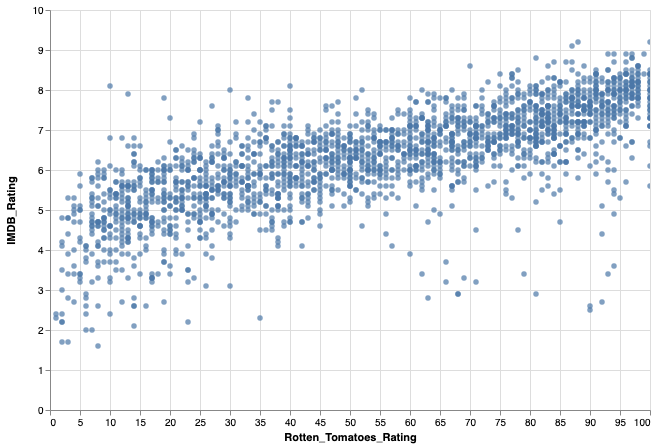

In [12]:
alt.Chart(movies).mark_circle().add_selection(
    alt.selection_interval(bind='scales')
).encode(
    x='Rotten_Tomatoes_Rating:Q',
    y=alt.Y('IMDB_Rating:Q', axis=alt.Axis(minExtent=30)), # use min extent to stabilize axis title placement
    tooltip=['Title:N', 'Release_Date:N', 'IMDB_Rating:Q', 'Rotten_Tomatoes_Rating:Q']
).properties(
    width=600,
    height=400
)

_Zooming in, we can see that the rating values have limited precision! The Rotten Tomatoes ratings are integers, while the IMDB ratings are truncated to tenths. As a result, there is overplotting even when we zoom, with multiple movies sharing the same rating values._

Reading the code above, you may notice the code `alt.Axis(minExtent=30)` in the `y` encoding channel. The `minExtent` parameter ensures a minimum amount of space is reserved for axis ticks and labels. Why do this? When we pan and zoom, the axis labels may change and cause the axis title position to shift. By setting a minimum extent we can reduce distracting movements in the plot. _Try changing the `minExtent` value, for example setting it to zero, and then zoom out to see what happens when longer axis labels enter the view._

Altair also includes a shorthand for adding panning and zooming to a plot. Instead of directly creating a selection, you can call `.interactive()` to have Altair automatically generate an interval selection bound to the chart's scales:

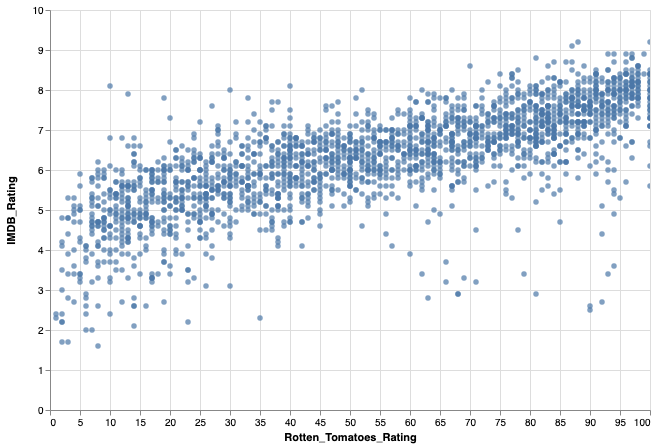

In [13]:
alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating:Q',
    y=alt.Y('IMDB_Rating:Q', axis=alt.Axis(minExtent=30)), # use min extent to stabilize axis title placement
    tooltip=['Title:N', 'Release_Date:N', 'IMDB_Rating:Q', 'Rotten_Tomatoes_Rating:Q']
).properties(
    width=600,
    height=400
).interactive()

By default, scale bindings for selections include both the `x` and `y` encoding channels. What if we want to limit panning and zooming along a single dimension? We can invoke `encodings=['x']` to constrain the selection to the `x` channel only:

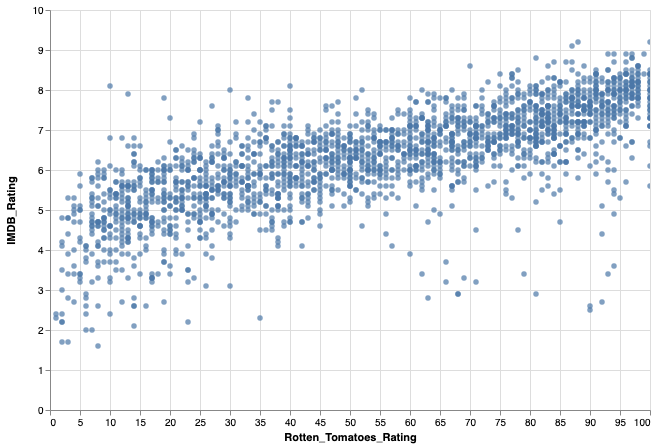

In [14]:
alt.Chart(movies).mark_circle().add_selection(
    alt.selection_interval(bind='scales', encodings=['x'])
).encode(
    x='Rotten_Tomatoes_Rating:Q',
    y=alt.Y('IMDB_Rating:Q', axis=alt.Axis(minExtent=30)), # use min extent to stabilize axis title placement
    tooltip=['Title:N', 'Release_Date:N', 'IMDB_Rating:Q', 'Rotten_Tomatoes_Rating:Q']
).properties(
    width=600,
    height=400
)

_When zooming along a single axis only, the shape of the visualized data can change, potentially affecting our perception of relationships in the data. [Choosing an appropriate aspect ratio](http://vis.stanford.edu/papers/arclength-banking) is an important visualization design concern!_

## Navigation: Overview + Detail

When panning and zooming, we directly adjust the "viewport" of a chart. The related navigation strategy of _overview + detail_ instead uses an overview display to show _all_ of the data, while supporting selections that pan and zoom a separate focus display.

Below we have two area charts showing a decade of price fluctuations for the S&amp;P 500 stock index. Initially both charts show the same data range. _Click and drag in the bottom overview chart to update the focus display and examine specific time spans._

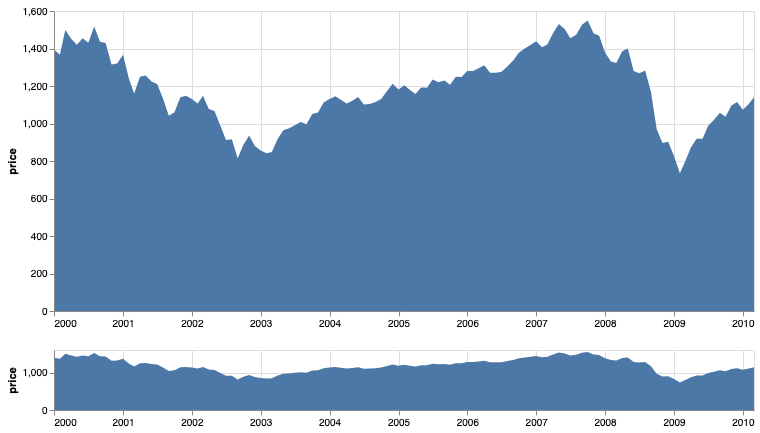

In [15]:
brush = alt.selection_interval(encodings=['x']);

base = alt.Chart().mark_area().encode(
    alt.X('date:T', title=None),
    alt.Y('price:Q')
).properties(
    width=700
)
  
alt.vconcat(
    base.encode(alt.X('date:T', title=None, scale=alt.Scale(domain=brush))),
    base.add_selection(brush).properties(height=60),
    data=sp500
)

Unlike our earlier panning &amp; zooming case, here we don't want to bind a selection directly to the scales of a single interactive chart. Instead, we want to bind the selection to a scale domain in _another_ chart. To do so, we update the `x` encoding channel for our focus chart, setting the scale `domain` property to reference our `brush` selection. If no interval is defined (the selection is empty), Altair ignores the brush and uses the underlying data to determine the domain. When a brush interval is created, Altair instead uses that as the scale `domain` for the focus chart.

## Details on Demand

Once we spot points of interest within a visualization, we often want to know more about them. _Details-on-demand_ refers to interactively querying for more information about selected values. _Tooltips_ are one useful means of providing details on demand. However, tooltips typically only show information for one data point at a time. How might we show more?

The movie ratings scatterplot includes a number of potentially interesting outliers where the Rotten Tomatoes and IMDB ratings disagree. Let's create a plot that allows us to interactively select points and show their labels.

_Mouse over points in the scatter plot below to see a highlight and title label. Shift-click points to make annotations persistent and view multiple labels at once. Which movies are loved by Rotten Tomatoes critics, but not the general audience on IMDB (or vice versa)? See if you can find possible errors, where two different movies with the same name were accidentally combined!_

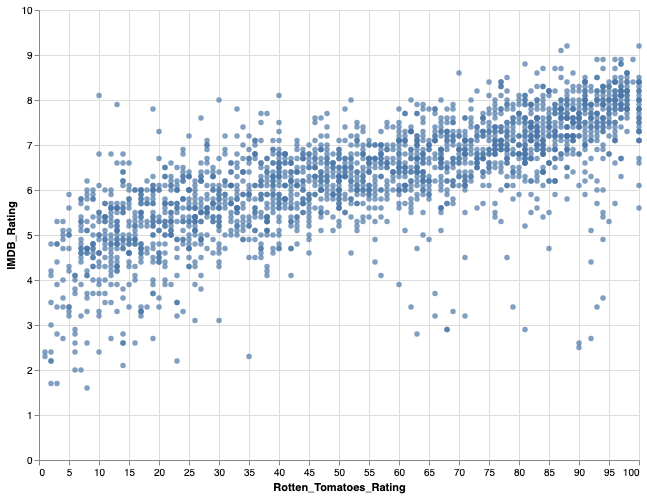

In [16]:
hover = alt.selection_single(
    on='mouseover',  # select on mouseover
    nearest=True,    # select nearest point to mouse cursor
    empty='none'     # empty selection should match nothing
)

click = alt.selection_multi(
    empty='none' # empty selection matches no points
)

# scatter plot encodings shared by all marks
plot = alt.Chart().mark_circle().encode(
    x='Rotten_Tomatoes_Rating:Q',
    y='IMDB_Rating:Q'
)
  
# shared base for new layers
base = plot.transform_filter(
    # logical OR is supported by Vega-Lite, nice syntax still needed for Altair
    {'or': [hover, click]} # filter to points in either selection
)

# layer scatter plot points, halo annotations, and title labels
alt.layer(
    plot.add_selection(hover).add_selection(click),
    base.mark_point(size=100, stroke='firebrick', strokeWidth=1),
    base.mark_text(dx=4, dy=-8, align='right', stroke='white', strokeWidth=2).encode(text='Title:N'),
    base.mark_text(dx=4, dy=-8, align='right').encode(text='Title:N'),
    data=movies
).properties(
    width=600,
    height=450
)

The example above adds three new layers to the scatter plot: a circular annotation, white text to provide a legible background, and black text showing a film title. In addition, this example uses two selections in tandem:

1. A single selection (`hover`) that includes `nearest=True` to automatically select the nearest data point as the mouse moves.
2. A multi selection (`click`) to create persistent selections via shift-click.

Both selections include the set `empty='none'` to indicate that no points should be included if a selection is empty. These selections are then combined into a single filter predicate &mdash; the logical _or_ of `hover` and `click` &mdash; to include points that reside in _either_ selection. We use this predicate to filter the new layers to show annotations and labels for selected points only.

Using selections and layers, we can realize a number of different designs for details on demand! For example, here is a log-scaled time series of technology stock prices, annotated with a guideline and labels for the date nearest the mouse cursor:

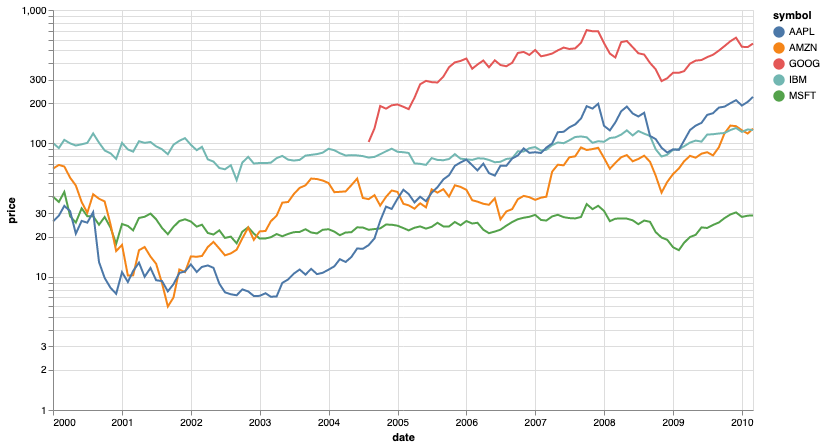

In [17]:
# select a point for which to provide details-on-demand
label = alt.selection_single(
    encodings=['x'], # limit selection to x-axis value
    on='mouseover',  # select on mouseover events
    nearest=True,    # select data point nearest the cursor
    empty='none'     # empty selection includes no data points
)

# define our base line chart of stock prices
base = alt.Chart().mark_line().encode(
    alt.X('date:T'),
    alt.Y('price:Q', scale=alt.Scale(type='log')),
    alt.Color('symbol:N')
)

alt.layer(
    base, # base line chart
    
    # add a rule mark to serve as a guide line
    alt.Chart().mark_rule(color='#aaa').encode(
        x='date:T'
    ).transform_filter(label),
    
    # add circle marks for selected time points, hide unselected points
    base.mark_circle().encode(
        opacity=alt.condition(label, alt.value(1), alt.value(0))
    ).add_selection(label),

    # add white stroked text to provide a legible background for labels
    base.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
        text='price:Q'
    ).transform_filter(label),

    # add text labels for stock prices
    base.mark_text(align='left', dx=5, dy=-5).encode(
        text='price:Q'
    ).transform_filter(label),
    
    data=stocks
).properties(
    width=700,
    height=400
)

_Putting into action what we've learned so far: can you modify the movie scatter plot above (the one with the dynamic query over years) to include a `rule` mark that shows the average IMDB (or Rotten Tomatoes) rating for the data contained within the year `interval` selection?_

## Brushing &amp; Linking, Revisited

Earlier in this notebook we saw an example of _brushing &amp; linking_: using a dynamic query histogram to highlight points in a movie rating scatter plot. Here, we'll visit some additional examples involving linked selections.

Returning to the `cars` dataset, we can use the `repeat` operator to build a [scatter plot matrix (SPLOM)](https://en.wikipedia.org/wiki/Scatter_plot#Scatterplot_matrices) that shows associations between mileage, acceleration, and horsepower. We can define an `interval` selection and include it _within_ our repeated scatter plot specification to enable linked selections among all the plots.

_Click and drag in any of the plots below to perform brushing &amp; linking!_

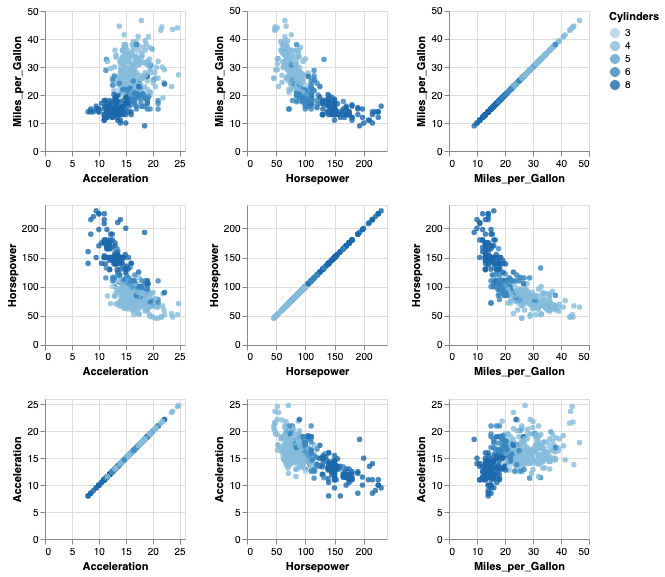

In [18]:
brush = alt.selection_interval(
    resolve='global' # resolve all selections to a single global instance
)

alt.Chart(cars).mark_circle().add_selection(
    brush
).encode(
    alt.X(alt.repeat('column'), type='quantitative'),
    alt.Y(alt.repeat('row'), type='quantitative'),
    color=alt.condition(brush, 'Cylinders:O', alt.value('grey')),
    opacity=alt.condition(brush, alt.value(0.8), alt.value(0.1))
).properties(
    width=140,
    height=140
).repeat(
    column=['Acceleration', 'Horsepower', 'Miles_per_Gallon'],
    row=['Miles_per_Gallon', 'Horsepower', 'Acceleration']
)

Note above the use of `resolve='global'` on the `interval` selection. The default setting of `'global'` indicates that across all plots only one brush can be active at a time. However, in some cases we might want to define brushes in multiple plots and combine the results. If we use `resolve='union'`, the selection will be the _union_ of all brushes: if a point resides within any brush it will be selected. Alternatively, if we use `resolve='intersect'`, the selection will consist of the _intersection_ of all brushes: only points that reside within all brushes will be selected.

_Try setting the `resolve` parameter to `'union'` and `'intersect'` and see how it changes the resulting selection logic._

### Cross-Filtering

The brushing &amp; linking examples we've looked at all use conditional encodings, for example to change opacity values in response to a selection. Another option is to use a selection defined in one view to _filter_ the content of another view.

Let's build a collection of histograms for the `flights` dataset: arrival `delay` (how early or late a flight arrives, in minutes), `distance` flown (in miles), and `time` of departure (hour of the day). We'll use the `repeat` operator to create the histograms, and add an `interval` selection for the `x` axis with brushes resolved via intersection.

In particular, each histogram will consist of two layers: a gray background layer and a blue foreground layer, with the foreground layer filtered by our intersection of brush selections. The result is a _cross-filtering_ interaction across the three charts!

_Drag out brush intervals in the charts below. As you select flights with longer or shorter arrival delays, how do the distance and time distributions respond?_

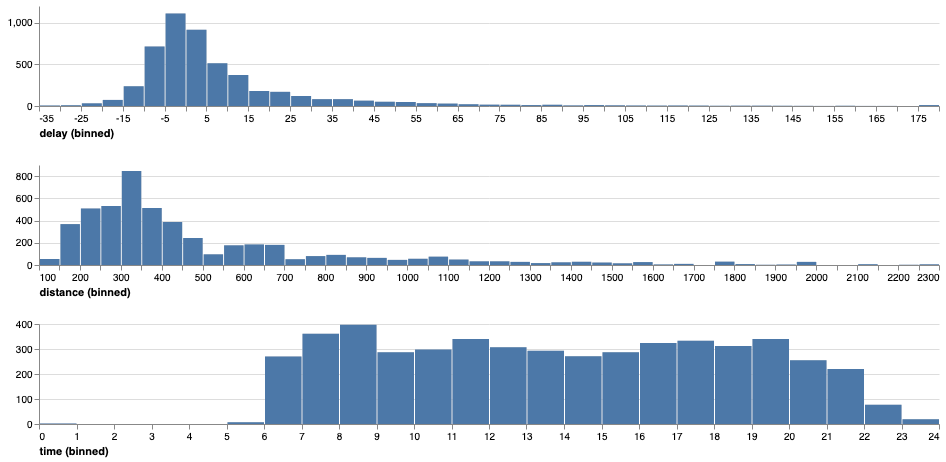

In [19]:
brush = alt.selection_interval(
    encodings=['x'],
    resolve='intersect'
);

hist = alt.Chart().mark_bar().encode(
    alt.X(alt.repeat('row'), type='quantitative',
        bin=alt.Bin(maxbins=100, minstep=1), # up to 100 bins
        axis=alt.Axis(format='d', titleAnchor='start') # integer format, left-aligned title
    ),
    alt.Y('count():Q', title=None) # no y-axis title
)
  
alt.layer(
    hist.add_selection(brush).encode(color=alt.value('lightgrey')),
    hist.transform_filter(brush)
).properties(
    width=900,
    height=100
).repeat(
    row=['delay', 'distance', 'time'],
    data=flights
).transform_calculate(
    delay='datum.delay < 180 ? datum.delay : 180', # clamp delays > 3 hours
    time='hours(datum.date) + minutes(datum.date) / 60' # fractional hours
).configure_view(
    stroke='transparent' # no outline
)

_By cross-filtering you can observe that delayed flights are more likely to depart at later hours. This phenomenon is familiar to frequent fliers: a delay can propagate through the day, affecting subsequent travel by that plane. For the best odds of an on-time arrival, book an early flight!_

The combination of multiple views and interactive selections can enable valuable forms of multi-dimensional reasoning, turning even basic histograms into powerful input devices for asking questions of a dataset!

## Summary

For more information about the supported interaction options in Altair, please consult the [Altair interactive selection documentation](https://altair-viz.github.io/user_guide/interactions.html). For details about customizing event handlers, for example to compose multiple interaction techniques or support touch-based input on mobile devices, see the [Vega-Lite selection documentation](https://vega.github.io/vega-lite/docs/selection.html).

Interested in learning more?
- The _selection_ abstraction was introduced in the paper [Vega-Lite: A Grammar of Interactive Graphics](http://idl.cs.washington.edu/papers/vega-lite/), by Satyanarayan, Moritz, Wongsuphasawat, &amp; Heer.
- The PRIM-9 system (for projection, rotation, isolation, and masking in up to 9 dimensions) is one of the earliest interactive visualization tools, built in the early 1970s by Fisherkeller, Tukey, &amp; Friedman. [A retro demo video survives!](http://stat-graphics.org/movies/prim9.html)
- The concept of brushing &amp; linking was crystallized by Becker, Cleveland, &amp; Wilks in their 1987 article [Dynamic Graphics for Data Analysis](https://scholar.google.com/scholar?cluster=14817303117298653693).
- For a comprehensive summary of interaction techniques for visualization, see [Interactive Dynamics for Visual Analysis](https://queue.acm.org/detail.cfm?id=2146416) by Heer &amp; Shneiderman.
- Finally, for a treatise on what makes interaction effective, read the classic [Direct Manipulation Interfaces](https://scholar.google.com/scholar?cluster=15702972136892195211) paper by Hutchins, Hollan, &amp; Norman.

#### Appendix: On The Representation of Time

Earlier we observed a small bump in the number of movies in either 1969 and 1970. Where does that bump come from? And why 1969 _or_ 1970? The answer stems from a combination of missing data and how your computer represents time. 

Internally, dates and times are represented relative to the [UNIX epoch](https://en.wikipedia.org/wiki/Unix_time), in which time "zero" corresponds to the stroke of midnight on January 1, 1970 in [UTC time](https://en.wikipedia.org/wiki/Coordinated_Universal_Time), which runs along the [prime meridian](https://en.wikipedia.org/wiki/Prime_meridian). It turns out there are a few movies with missing (`null`) release dates. Those `null` values get interpreted as time `0`, and thus map to January 1, 1970 in UTC time. If you live in the Americas &ndash; and thus in "earlier" time zones &ndash; this precise point in time corresponds to an earlier hour on December 31, 1969 in your local time zone. On the other hand, if you live near or east of the prime meridian, the date in your local time zone will be January 1, 1970.

The takeaway? Always be skeptical of your data, and be mindful that how data is represented (whether as date times, or floating point numbers, or latitudes and longitudes, _etc._) can sometimes lead to artifacts that impact analysis!